## Shapley effects for $RC$ and $\theta_{11}$

In [1]:
import os
import profile
import pickle
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import chaospy as cp
from functools import partial
from joblib import Parallel, delayed
from ruspy.estimation.estimation import estimate
from ruspy.model_code.fix_point_alg import calc_fixp
from ruspy.model_code.cost_functions import lin_cost
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.estimation.estimation_transitions import create_transition_matrix
from ruspy.model_code.demand_function import get_demand
from econsa.shapley import get_shapley
from python.auxiliary import rust_model_shapley
from python.auxiliary import x_all_raw
from python.auxiliary import x_cond_raw
from python.auxiliary import simulate_cov_and_mean_rc_theta_11
from python.auxiliary import approx_comp_time
from python.auxiliary import compute_confidence_intervals
from python.auxiliary import setup_rust_model_001

In [2]:
run_simulation_cov_mean = False
run_simulation_shapley_effects = True

In [3]:
model_setup = setup_rust_model_001()
params = model_setup['params']
ev = model_setup['ev']
costs = model_setup['costs']
trans_probs = model_setup['trans_probs']
trans_mat = model_setup['trans_mat']
init_dict_simulation = model_setup['init_dict_simulation']
init_dict_estimation = model_setup['init_dict_estimation']
demand_dict = model_setup['demand_dict']

In [4]:
%%time
# Simulation of 5,000 samples takes 3h 27min. (When using older version of the simulaton function.)
# Simulation of 10,000 samples takes 8h 33min 21s. (New version of function.)
num_sim = 10 ** 4
if run_simulation_cov_mean is True:
    cov, mean = simulate_cov_and_mean_rc_theta_11(num_sim, ev, costs, trans_mat, init_dict_simulation, init_dict_estimation)
    np.save(os.path.join('data', f'cov_rc_theta_11_{num_sim}'), cov)
    np.save(os.path.join('data', f'mean_rc_theta_11_{num_sim}'), mean)
elif run_simulation_cov_mean is False:
    cov = np.load(os.path.join('data', f'cov_rc_theta_11_{num_sim}.npy'))
    mean = np.load(os.path.join('data', f'mean_rc_theta_11_{num_sim}.npy'))
else:
    raise ValueError

Wall time: 34 ms


In [5]:
cov_nice = pd.DataFrame(data=cov, index= ['$RC$', '$\theta_{11}$'], columns=['$RC$', '$\theta_{11}$'])
cov_nice

,$RC$,$\theta_{11}$
$RC$,1.604736,0.605903
$\theta_{11}$,0.605903,0.273094


In [6]:
mean_nice = pd.DataFrame(data=np.concatenate((mean, params)).reshape([2, 2], order='F'), 
                         index= ['$RC$', '$\theta_{11}$'], columns=['Empirical mean', 'True mean'])
mean_nice

,Empirical mean,True mean
$RC$,10.388616,10.077808
$\theta_{11}$,2.418207,2.294176


In [7]:
# Test: save data frame as .csv.
#mean_nice.to_pickle(path_or_buf=os.path.join('data', 'mean_nice'))

#### Define function arguments for `get_shapley()`.

In [8]:
n_inputs = 2
n_perms = None
method = 'exact'
np.random.seed(1234)

#### Until here: arguments do not change.

In [13]:
# Define number of simulations.
n_output = 10**2
n_outer = 10
n_inner = 3

# Define model, and sampling functions.
model = partial(
    rust_model_shapley, method=method, n_perms=n_perms, n_inputs=n_inputs, n_output=n_output, n_outer=n_outer, n_inner=n_inner, trans_probs=trans_probs, 
    init_dict_estimation=init_dict_estimation, demand_dict=demand_dict, 
)
x_all_partial = partial(x_all_raw, mean=params, cov=cov)
x_cond_partial = partial(x_cond_raw, mean=params, cov=cov)

In [14]:
%%time
# Using new version of rust_model_shapley which uses Joblib, one run takes about 23.9 s.
# A single run. Time with three trans_probs: ~ 54 s.
# With four trans_probs: ~ 19 m.

exact_shapley = get_shapley(method, model, x_all_partial, x_cond_partial, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 23.9 s


## Run `get_shapley` for large number of samples.

In [15]:
# Define number of simulations.
n_output = 10 ** 3
n_outer = 10 ** 4
n_inner = 10

# Define model, and sampling functions.
model = partial(
    rust_model_shapley, method=method, n_perms=n_perms, n_inputs=n_inputs, n_output=n_output, n_outer=n_outer, n_inner=n_inner, trans_probs=trans_probs, 
    init_dict_estimation=init_dict_estimation, demand_dict=demand_dict, 
)
x_all_partial = partial(x_all_raw, mean=params, cov=cov)
x_cond_partial = partial(x_cond_raw, mean=params, cov=cov)

# Duration for 100 evaluations.
time_model_eval = 26
approx_comp_time(time_model_eval, method, n_inputs, n_perms, n_output, n_outer, n_inner)

201000 model evaulations. 
 Approx. 14.516666666666667 hours. 
 Approx. 871.0 minutes


In [11]:
%%time
# 1. n_v = 10 ** 4, n_o = 10 ** 3, n_i = 3 takes 38min 34s. std error = 0.297163. 16,000 model evals.
# 2. n_v = 10 ** 4, n_o = 10 ** 3, n_i = 10 takes 1h 31min 18s. std error = 0.29738. 30,000 model evals.
# 3. n_v = 10 **4, n_o = 10 ** 4, n_i = 3 takes 3h 3min 20s. std error = 0.296572. 70,000 model evals.

np.random.seed(123)

exact_shapley = get_shapley(method, model, x_all_partial, x_cond_partial, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 3h 3min 20s


In [16]:
exact_shapley # 3.

,Shapley effects,std. errors,CI_min,CI_max
$RC$,0.419416,0.296572,-0.161865,1.000696
$\theta_{11}$,0.580584,0.296572,-0.000696,1.161865


In [27]:
exact_shapley # 2.

,Shapley effects,std. errors,CI_min,CI_max
$RC$,0.420558,0.29738,-0.162306,1.003422
$\theta_{11}$,0.579442,0.29738,-0.003422,1.162306


In [23]:
exact_shapley # 1.

,Shapley effects,std. errors,CI_min,CI_max
$RC$,0.420251,0.297163,-0.162187,1.002690
$\theta_{11}$,0.579749,0.297163,-0.002690,1.162187



## Create 100 replicates of the Shapley effects for small simulation numbers.

In [ ]:
n_jobs = os.cpu_count()

def shapley_replicate(current_seed):
    init_dict_simulation["simulation"]["seed"] = current_seed

    model = partial(rust_model_shapley, method=method, n_perms=n_perms, n_inputs=n_inputs, n_output=n_output, n_outer=n_outer, n_inner=n_inner,                         trans_probs=trans_probs, init_dict_estimation=init_dict_estimation, demand_dict=demand_dict)

    x_all_partial = partial(x_all_raw, mean=params, cov=cov)
    x_cond_partial = partial(x_cond_raw, mean=params, cov=cov)

    exact_shapley = get_shapley(method, model, x_all_partial, x_cond_partial, n_perms, n_inputs, n_output, n_outer, n_inner, n_jobs)
    exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)
    return exact_shapley

In [6]:
%%time
# n_replicates runs.

# 100 replicates ~ 1 h 30 m.

# 200 replicates ~ 2 h 37 m.

np.random.seed(1234)

n_replicates = 500

if run_simulation_shapley_effects is True:
    shapley_effects = list(map(shapley_replicate, np.arange(n_replicates)))
    # For loop. Get a sense of how it works. Later get functions and run for larger number of simulations.
    # shapley_effects = {}
    # for i in np.arange(n_replicates):
    #     np.random.seed(i)
    #     exact_shapley = get_shapley(method, model, x_all_partial, x_cond_partial, n_perms, n_inputs, n_output, n_outer, n_inner)
    #     exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)
    #     shapley_effects[i] = exact_shapley
    with open(os.path.join('data', f'shapley_effects_{n_replicates}_runs.pickle'), 'wb') as handle:
        pickle.dump(shapley_effects, handle)
else:
    with open(os.path.join('data', f'shapley_effects_{n_replicates}_runs.pickle'), 'rb') as handle:
        shapley_effects = pickle.load(handle)

Wall time: 143 ms


In [7]:
# Get data frame suitable for plotting.
rc_shapley_effects = [shapley_effects[i]['Shapley effects']['$RC$'] for i in np.arange(n_replicates)]
theta_shapley_effects = [shapley_effects[i]['Shapley effects']['$\theta_{11}$'] for i in np.arange(n_replicates)]

rc_shapley_effects_df = pd.DataFrame(data=rc_shapley_effects)
rc_shapley_effects_df['input_variable'] = 'rc'

theta_shapley_effects_df = pd.DataFrame(data=theta_shapley_effects)
theta_shapley_effects_df['input_variable'] = 'theta'

data = pd.concat([rc_shapley_effects_df, theta_shapley_effects_df], ignore_index=True)
data.rename(columns={0: 'shapley_effect'}, inplace=True)

In [8]:
# For calculation of variance use Bessel's correction (by specifying ddof=1 in np.var()).

variance_rc_shapley_effects = np.var(rc_shapley_effects, ddof=1)
mean_rc_shapley_effects = np.mean(rc_shapley_effects)

variance_theta_shapley_effects = np.var(theta_shapley_effects, ddof=1)
mean_theta_shapley_effects = np.mean(theta_shapley_effects)

# Calc. std. errors. (std. dev. / sqrt(n)).
se_rc_shapley_effects = np.sqrt(variance_rc_shapley_effects) / np.sqrt(n_replicates)

se_theta_shapley_effects = np.sqrt(variance_theta_shapley_effects) / np.sqrt(n_replicates)

# Critical value of the 95-percent confidence interval.
crit_value = 1.96

ci_rc = compute_confidence_intervals(mean_rc_shapley_effects, se_rc_shapley_effects, crit_value)

ci_theta = compute_confidence_intervals(mean_theta_shapley_effects, se_theta_shapley_effects, crit_value)

In [9]:
ci_rc

{'lower_bound': 0.41051943706753014, 'upper_bound': 0.42072878601656893}

In [10]:
ci_theta

{'lower_bound': 0.5792712139834312, 'upper_bound': 0.5894805629324699}

In [13]:
# Descriptives of the replicates.

descriptives_data = np.array([[mean_rc_shapley_effects, 
                               se_rc_shapley_effects, 
                               ci_rc['lower_bound'], 
                               ci_rc['upper_bound']
                              ],
                              
                              [mean_theta_shapley_effects, 
                               se_theta_shapley_effects, 
                               ci_theta['lower_bound'], 
                               ci_theta['upper_bound']
                              ]
                             ])

descriptives_shapley_effects = pd.DataFrame(descriptives_data, 
                                            columns=['Mean', 'Std. errors', 'CI lower bound', 'CI upper bound'], 
                                            index=['$RC$', '$\theta_{11}$']
                                           )
descriptives_shapley_effects.index.name = 'Shapley Effect'

In [14]:
descriptives_shapley_effects

,Mean,Std. errors,CI lower bound,CI upper bound
Shapley Effect,,,,
$RC$,0.415624,0.002604,0.410519,0.420729
$\theta_{11}$,0.584376,0.002604,0.579271,0.589481


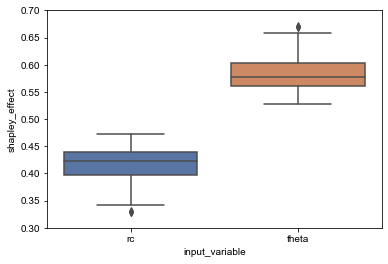

In [15]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
ax.set(ylim=(0.3, 0.7))
ax = sns.boxplot(x=data['input_variable'], y=data['shapley_effect'])

In [16]:
fig.savefig(fname=os.path.join('figures', f'boxplot_shapley_effects_{n_replicates}'), dpi=1000)

Alternative visualisation of the Shapley effects.

In [48]:
plot_dict = {
    0: 'RC',
    1: 'theta'
}

In [49]:
array_shapley_effects = np.array([rc_shapley_effects, theta_shapley_effects])

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


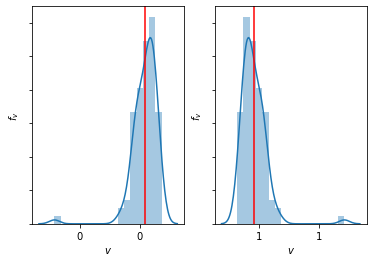

In [52]:
fig, ax = plt.subplots(1, 2)


#sns.distplot(theta_shapley_effects, ax=ax[1])

for k, v in plot_dict.items():
    sns.distplot(array_shapley_effects[k], ax=ax[k])
    
    ax[k].set_xlabel(r"${v}$")
    ax[k].set_ylabel(r"$f_{v}$")
    
    ax[k].axvline(x=np.mean(array_shapley_effects[k]), ymin=0, ymax=1, color='red')
    #ax[0].axvline(x=mean_rc_shapley_effects, ymin=0, ymax=1, color='red')

    #ax[1].axvline(x=mean_theta_shapley_effects, ymin=0, ymax=1, color='grey')

    ax[k].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[k].axes.get_yaxis().set_ticklabels([])

## Run `get_shapley()` for different sample sizes.

Run for large no. of MC runs.

In [11]:
n_output = 10**3
n_outer = 10**2
n_inner = 20
# Time in s for 100 model evaluations.
time_model_eval = 35
approx_comp_time(time_model_eval, method, n_inputs, n_perms, n_output, n_outer, n_inner)

 5000 model evaluations 
 approx.  0.4861111111111111 hours 
 approx. 29.166666666666668 minutes


In [12]:
%%time

exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 33min 15s


In [13]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.422186,0.29853,-0.162934,1.007305
theta_11,0.577814,0.29853,-0.007305,1.162934


Another try with even larger no.s

In [20]:
n_output = 10**3
n_outer = 10**2
n_inner = 40
# Time in s for 100 model evaluations.
time_model_eval = 37
approx_comp_time(time_model_eval, method, n_inputs, n_perms, n_output, n_outer, n_inner)

 9000 model evaluations 
 approx.  0.925 hours 
 approx. 55.5 minutes


In [18]:
%%time

exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 1h 3min 57s


In [19]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.413136,0.292131,-0.159441,0.985713
theta_11,0.586864,0.292131,0.014287,1.159441


In [18]:
list_num_sim = [{'n_output': 10**3, 'n_outer': 15, 'n_inner': 3}, 
                {'n_output': 10**3, 'n_outer': 15, 'n_inner': 5}, 
                {'n_output': 10**3, 'n_outer': 15, 'n_inner': 7}, 
                {'n_output': 10**3, 'n_outer': 20, 'n_inner': 3}, 
                {'n_output': 10**3, 'n_outer': 20, 'n_inner': 7}]

In [12]:
%%time

exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 6min 44s


In [13]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.425934,0.301181,-0.164381,1.016249
theta_11,0.574066,0.301181,-0.016249,1.164381


Try with larger no. of MC runs.

In [29]:
%%time
n_output = 10**2
n_outer = 40
n_inner = 20
exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 11min 22s


In [30]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.437425,0.309306,-0.168815,1.043666
theta_11,0.562575,0.309306,-0.043666,1.168815


In [27]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.386826,0.273527,-0.149287,0.922939
theta_11,0.613174,0.273527,0.077061,1.149287


#### Run the following code over night 

In [54]:
n_output = 20**3
n_outer = 20**2
n_inner = 10**2
# Time in s for 100 model evaluations.
time_model_eval = 40
approx_comp_time(time_model_eval, method, n_inputs, n_perms, n_output, n_outer, n_inner)

 88000 model evaluations 
 approx.  9.777777777777779 hours 
 approx. 586.6666666666667 minutes


In [ ]:
exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

#### Run for $RC_{fixed}$ close to true $RC$

In [12]:
# Need demand at certain value of RC only.  Note RC is scaled by 1e-03.
demand_dict = {
    "RC_lower_bound": 10.0,
    "RC_upper_bound": 10.0,
    "demand_evaluations": 1,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}

In [13]:
%%time
n_output = 10**3
n_outer = 15
n_inner = 3
exact_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)
exact_shapley.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 5min 10s


In [14]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
RC,0.425773,0.301067,-0.164318,1.015864
theta_11,0.574227,0.301067,-0.015864,1.164318


## Uncertainty Propagation
Inspection of the distribution of the implied demand at certain $RC_{fixed}$.

In [5]:
# Sample data.
num_sim_demand = 10 ** 4
input_variables = cp.MvNormal(params, cov).sample(num_sim_demand).T

In [6]:
get_demand_partial = partial(get_demand, init_dict=init_dict_estimation, demand_dict=demand_dict)
def get_demand_mapping(x):
    return get_demand_partial(demand_params=x).iloc[0]['demand']

In [7]:
demand_inputs = np.zeros((num_sim_demand, 5))
demand_inputs[:, :3] = np.array([0.39189182, 0.59529371, 0.01281447])
demand_inputs[:, 3:] = input_variables[:, :]

In [8]:
%%time
# Use Joblib. 10 ** 4 runs take 30min 33s.
n_cores = os.cpu_count()
implied_demand = Parallel(n_jobs=n_cores)(
        delayed(get_demand_mapping)(inp) for inp in demand_inputs
    )
# implied_demand = np.array(list(map(get_demand_mapping, demand_inputs)))

Wall time: 30min 33s


In [9]:
true_demand_params = np.concatenate((trans_probs, params))
true_implied_demand = get_demand(init_dict_estimation, demand_dict, true_demand_params).iloc[0]['demand']

In [10]:
true_implied_demand

59.08876072857218

In [11]:
# mean_implied_demand = np.mean(implied_demand)

In [12]:
type(implied_demand)

list

In [13]:
input_variables

array([[ 7.35940991,  1.21680059],
       [11.43578874,  3.19949566],
       [ 8.93389102,  1.61327933],
       ...,
       [10.93574417,  2.60961343],
       [ 9.83841299,  1.93582566],
       [ 9.11384284,  1.67910677]])

In [22]:
implied_demand = np.asarray(implied_demand)

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.0, ''),
 Text(0, 0.01, ''),
 Text(0, 0.02, ''),
 Text(0, 0.03, ''),
 Text(0, 0.04, ''),
 Text(0, 0.05, ''),
 Text(0, 0.06, ''),
 Text(0, 0.07, '')]

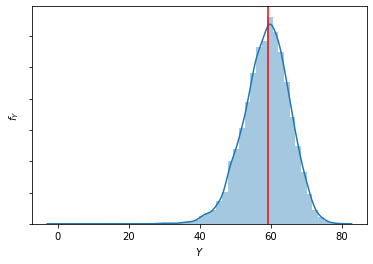

In [15]:
fig, ax = plt.subplots()

sns.distplot(implied_demand)

ax.set_xlabel(r"$Y$")
ax.set_ylabel(r"$f_Y$")

ax.axvline(x=true_implied_demand, ymin=0, ymax=1, color='red')

# ax.axvline(x=mean_implied_demand, ymin=0, ymax=1, color='grey')

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.axes.get_yaxis().set_ticklabels([])

In [16]:
# Save to png.
fig.savefig(fname=os.path.join('figures', f'uncertainty_propagation_{num_sim_demand}'), dpi=1000)

### 3d Plot: $Y$ as a function of $RC$ and $\theta_{11}$.

In [43]:
data = pd.DataFrame(np.hstack((input_variables, implied_demand.reshape(10 ** 4, 1))), columns=['RC', 'theta_11', 'Y'])

In [44]:
data

,RC,theta_11,Y
0,7.359410,1.216801,43.976736
1,11.435789,3.199496,69.010330
2,8.933891,1.613279,50.146321
3,12.715644,3.000896,66.976212
4,8.157252,1.640756,50.542300
...,...,...,...
9995,10.025240,2.344269,59.687004
9996,10.112841,2.573666,62.343746
9997,10.935744,2.609613,62.748526
9998,9.838413,1.935826,54.590533


In [33]:
# To long format.
# df = data.unstack().reset_index()
# df.columns = ["X","Y","Z"] # latitude, longitude, altitude.

In [31]:
# Transform the old column name in something numeric.
# df['X'] = pd.Categorical(df['X'])
# df['X'] = df['X'].cat.codes

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


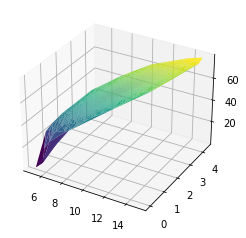

In [46]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data['RC'], data['theta_11'], data['Y'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()